In [1]:
import pandas as pd
import numpy as np
import sys
import os
import math

## Load Single Model Profiles

In [2]:
from single_model_profiles import create_model_profile_df as create_df

In [3]:
resnet_relative_path = "../results/single_model_profs/tf-resnet"
inception_relative_path = "../results/single_model_profs/tf-inception"
ksvm_relative_path = "../results/single_model_profs/tf-kernel-svm"
log_reg_relative_path = "../results/single_model_profs/tf-log-reg"

In [4]:
resnet_df = create_df(resnet_relative_path)[1]
inception_df = create_df(inception_relative_path)[1]
ksvm_df = create_df(ksvm_relative_path)[1]
log_reg_df = create_df(log_reg_relative_path)[1]

0.1189154325
0.3605081425
0.4702417975
0.54887086
0.6907454675
0.7988997675
0.92695537
1.1373771975
1.6110220125
1.9427511525
3.084771625
3.9650773175
0.231472785
0.2408045525
0.5048830375
0.605466375
0.7637659525
0.8195698
1.2252030875
1.77642884
2.19061436
2.8082347375
4.2711755725
0.0896488175
0.0192459875
0.04587359
0.0438752475
0.0478582175
0.0489624875
0.0496466775
0.054228235
0.059671935
0.058097735
0.057423845
0.0583314725
0.0567175925
0.005891105
0.00563008
0.005437605
0.0054933975
0.0058617125
0.0051004825
0.0049547875
0.004893265
0.0052897825
0.00498865
0.0047672525
0.0049984675


## Find Optimal Batch Sizes

In [5]:
def config_value(cost, throughput):
    return float(throughput) / float(cost)

In [6]:
def find_optimal_batch_config(df, slo=None):
    slim_df = df[["mean_batch_size", "mean_throughput_qps", "cost", "p99_latency"]]
    best_config = None
    best_value = 0
    for idx, row in slim_df.iterrows():
        batch_size = row["mean_batch_size"]
        throughput = row["mean_throughput_qps"]
        cost = row["cost"]
        latency = row["p99_latency"]
        value = config_value(cost, throughput)
        if value > best_value and ((slo == None) or (latency <= slo)):
            best_config = (batch_size, throughput, latency)
            best_value = value
        
        
    return best_config
    
find_optimal_batch_config(resnet_df, slo=None)

(63.939999999999998, 51.435861782134317, 4.0688784999999994)

In [7]:
resnet_config = find_optimal_batch_config(resnet_df)
inception_config = find_optimal_batch_config(inception_df)
ksvm_config = find_optimal_batch_config(ksvm_df)
log_reg_config = find_optimal_batch_config(log_reg_df)

## Enumerate Pipeline Configurations

In [8]:
def get_configs(branches, slo=None):
    all_configs = {}
    for branch in branches:
        branch_configs = branch_helper(branch, slo_budget=slo)
        for config in branch_configs:
            all_configs = all_configs.copy()
            all_configs.update(config)
        
    return all_configs
                    
def branch_helper(branch, slo_budget):
    branch = list(branch)
    model_name, model_df = branch.pop(0)
    if len(branch) == 0:
        optimal_config = find_optimal_batch_config(model_df, slo=slo_budget)
        if not optimal_config:
            return None
        else:
            return [{model_name : optimal_config}]
    else:
        while True:
            optimal_config = find_optimal_batch_config(model_df, slo=slo_budget)
            batch_size, throughput, latency = optimal_config
            if not optimal_config:
                return None
            else:
                if slo_budget:
                    new_budget = slo_budget - latency
                else:
                    new_budget = slo_budget
                next_configs = branch_helper(branch, new_budget)
                if next_configs:
                    return [{model_name : optimal_config}] + next_configs
                else:
                    # Configuration was bad, try another
                    model_df = model_df[model_df.mean_batch_size != batch_size]
                    print(model_df)   
                    
def get_min_lat_configs(branches):
    all_models = []
    for branch in branches:
        all_models = all_models + branch
        
    all_configs = {}
    while len(all_models) > 0:
        model_name, model_df = all_models.pop()
        min_df = model_df[model_df.mean_batch_size == 1.0]
        min_df = min_df[["mean_throughput_qps", "p99_latency"]]
        for idx, row in min_df.iterrows():
            throughput = row["mean_throughput_qps"]
            latency = row["p99_latency"]
            all_configs[model_name] = (1.0, throughput, latency)
            break
        
    return all_configs
        

In [9]:
resnet_ksvm_branch = [("tf-resnet", resnet_df), ("tf-ksvm", ksvm_df)]
inception_log_reg_branch = [("tf-inception", inception_df), ("tf-log-reg", log_reg_df)]
branches = [resnet_ksvm_branch, inception_log_reg_branch]

In [10]:
all_configs = get_configs(branches, slo=None)

## Determine Replication Strategy

In [11]:
def get_replications(gpu_configs, cpu_configs, num_gpus=8):
    
    def get_bottleneck_model(reps, configs):
        bottleneck_model_name = None
        bottleneck_throughput = None
        for model_name, config in configs.iteritems():
            _, model_throughput, _ = config
            total_throughput = reps[model_name] * model_throughput
            if not bottleneck_throughput or total_throughput < bottleneck_throughput:
                bottleneck_model_name = model_name
                bottleneck_throughput = total_throughput
                
        return bottleneck_model_name, bottleneck_throughput
        
    
    all_configs = gpu_configs.copy()
    all_configs.update(cpu_configs)
    
    curr_reps = {}
    for model_name, _ in all_configs.iteritems():
        curr_reps[model_name] = 1
        if model_name in gpu_configs:
            num_gpus -= 1
        
    all_reps = []
        
    while True:
        bottleneck_model_name, bottleneck_throughput = get_bottleneck_model(curr_reps, all_configs)
        if bottleneck_model_name in gpu_configs:
            if num_gpus == 0:
                break
            else:
                num_gpus -= 1
                
        all_reps.append((curr_reps.copy(), bottleneck_throughput))
        curr_reps[bottleneck_model_name] = curr_reps[bottleneck_model_name] + 1
        
    all_reps.append((curr_reps.copy(), bottleneck_throughput))
    
    return all_reps

In [12]:
all_configs 

{'tf-inception': (63.979999999999997, 73.198750383857913, 4.4407653399999996),
 'tf-ksvm': (13.62454357236966, 748.53549814695339, 0.060052110000000006),
 'tf-log-reg': (1.0033579795470664, 771.84295351497792, 0.0057492999999999997),
 'tf-resnet': (63.939999999999998, 51.435861782134317, 4.0688784999999994)}

In [13]:
gpu_configs = {k: all_configs[k] for k in ('tf-inception', 'tf-resnet')}
cpu_configs = {k: all_configs[k] for k in ('tf-ksvm', 'tf-log-reg')}

In [14]:
get_replications(gpu_configs=gpu_configs, cpu_configs=cpu_configs, num_gpus=8)

[({'tf-inception': 1, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 1},
  51.435861782134317),
 ({'tf-inception': 1, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 2},
  73.198750383857913),
 ({'tf-inception': 2, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 2},
  102.87172356426863),
 ({'tf-inception': 2, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 3},
  146.39750076771583),
 ({'tf-inception': 3, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 3},
  154.30758534640296),
 ({'tf-inception': 3, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 4},
  205.74344712853727),
 ({'tf-inception': 3, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 5},
  219.59625115157374)]

## Replications and expected throughputs for varying SLOs

### 500ms

In [15]:
half_second_configs = get_configs(list(branches), slo=.5)
half_second_gpu_configs = {k: half_second_configs[k] for k in ('tf-inception', 'tf-resnet')}
half_second_cpu_configs = {k: half_second_configs[k] for k in ('tf-ksvm', 'tf-log-reg')}
half_second_reps = get_replications(gpu_configs=half_second_gpu_configs, cpu_configs=half_second_cpu_configs, num_gpus=8)

### 1000ms

In [16]:
one_second_configs = get_configs(list(branches), slo=1)
one_second_gpu_configs = {k: one_second_configs[k] for k in ('tf-inception', 'tf-resnet')}
one_second_cpu_configs = {k: one_second_configs[k] for k in ('tf-ksvm', 'tf-log-reg')}
one_second_reps = get_replications(gpu_configs=one_second_gpu_configs, cpu_configs=one_second_cpu_configs, num_gpus=8)

### Max Thru

In [17]:
max_thru_configs = get_configs(list(branches), slo=None)
max_thru_gpu_configs = {k: max_thru_configs[k] for k in ('tf-inception', 'tf-resnet')}
max_thru_cpu_configs = {k: max_thru_configs[k] for k in ('tf-ksvm', 'tf-log-reg')}
max_thru_reps = get_replications(gpu_configs=max_thru_gpu_configs, cpu_configs=max_thru_cpu_configs, num_gpus=8)

### Min Lat

In [18]:
min_lat_configs = get_min_lat_configs(list(branches))
min_lat_gpu_configs = {k: min_lat_configs[k] for k in ('tf-inception', 'tf-resnet')}
min_lat_cpu_configs = {k: min_lat_configs[k] for k in ('tf-ksvm', 'tf-log-reg')}
min_lat_reps = get_replications(gpu_configs=min_lat_gpu_configs, cpu_configs=min_lat_cpu_configs, num_gpus=8)

## Plots

In [19]:
from matplotlib import pyplot as plt
from utils import COST_PER_GPU, COST_PER_CPU
% matplotlib inline

In [20]:
def get_thrus_costs(gpu_configs, reps):
    costs = []
    thrus = []
    for rep_config, throughput in reps:
        total_cost = 0
        for model_name, num_reps in rep_config.iteritems():
            cost = num_reps * COST_PER_CPU
            if model_name in gpu_configs:
                cost += num_reps * COST_PER_GPU
            total_cost += cost

        costs.append(total_cost)
        thrus.append(throughput)

    return thrus, costs

In [21]:
min_lat_thrus, min_lat_costs = get_thrus_costs(min_lat_gpu_configs, min_lat_reps)
max_thru_thrus, max_thru_costs = get_thrus_costs(max_thru_gpu_configs, max_thru_reps)
half_second_thrus, half_second_costs = get_thrus_costs(half_second_gpu_configs, half_second_reps)
one_second_thrus, one_second_costs = get_thrus_costs(one_second_gpu_configs, one_second_reps)

## Load E2E Results

In [24]:
from end_to_end_profiles import load_end_to_end_experiment as load_e2e

In [25]:
min_lat_relative_path = "../results/e2e_profs/systemx/image_driver_1/min_latency"
max_thru_relative_path = "../results/e2e_profs/systemx/image_driver_1/max_throughput"
half_second_relative_path = "../results/e2e_profs/systemx/image_driver_1/500ms"
one_second_relative_path = "../results/e2e_profs/systemx/image_driver_1/1000ms"

In [26]:
e2e_min_lat_df = load_e2e("min", min_lat_relative_path)[0]
e2e_max_thru_df = load_e2e("max", max_thru_relative_path)[0]
e2e_half_second_df = load_e2e("500ms", half_second_relative_path)[0]
e2e_one_second_df = load_e2e("1000ms", one_second_relative_path)[0]

## Plot Throughput vs Cost

In [27]:
def get_e2e_thrus_costs(e2e_df):
    thrus = []
    costs = []
    slim_df = e2e_df[["mean_throughput", "cost"]].sort_values("cost")
    for idx, row in slim_df.iterrows():
        thru = row["mean_throughput"]
        cost = row["cost"]
        thrus.append(thru)
        costs.append(cost)
        
    return thrus, costs

In [28]:
e2e_min_lat_thrus, e2e_min_lat_costs = get_e2e_thrus_costs(e2e_min_lat_df)
e2e_max_thru_thrus, e2e_max_thru_costs = get_e2e_thrus_costs(e2e_max_thru_df)
e2e_half_second_thrus, e2e_half_second_costs = get_e2e_thrus_costs(e2e_half_second_df)
e2e_one_second_thrus, e2e_one_second_costs = get_e2e_thrus_costs(e2e_one_second_df)

Percentage differences (relative to expectation): [-0.02693249  0.00270355 -0.03652318 -0.02894792 -0.05397909  0.01347234
 -0.02133543]


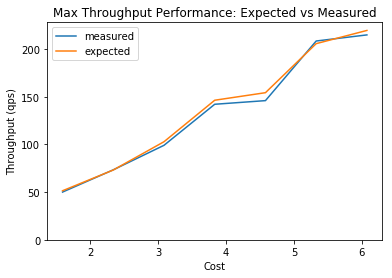

In [29]:
diffs = np.array(e2e_max_thru_thrus) - np.array(max_thru_thrus)
print("Percentage differences (relative to expectation): {}".format(diffs / max_thru_thrus))

plt.plot(max_thru_costs, e2e_max_thru_thrus, label="measured")
plt.plot(max_thru_costs, max_thru_thrus, label="expected")
plt.legend()
plt.ylim(bottom=0)
plt.xlabel("Cost")
plt.ylabel("Throughput (qps)")
plt.title("Max Throughput Performance: Expected vs Measured")

Percentage differences (relative to expectation): [-0.0293131  -0.02749768  0.01005153 -0.00724352 -0.06398227 -0.04093931
 -0.08556198]


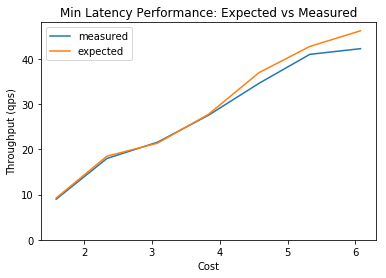

In [30]:
diffs = np.array(e2e_min_lat_thrus) - np.array(min_lat_thrus)
print("Percentage differences (relative to expectation): {}".format(diffs / min_lat_thrus))

plt.plot(e2e_min_lat_costs, e2e_min_lat_thrus, label="measured")
plt.plot(min_lat_costs, min_lat_thrus, label="expected")
plt.legend()
plt.ylim(bottom=0)
plt.xlabel("Cost")
plt.ylabel("Throughput (qps)")
plt.title("Min Latency Performance: Expected vs Measured")

Percentage differences (relative to expectation): [-0.20795664 -0.05895673 -0.16582893 -0.08197567 -0.05455202 -0.06942495
 -0.08209259]


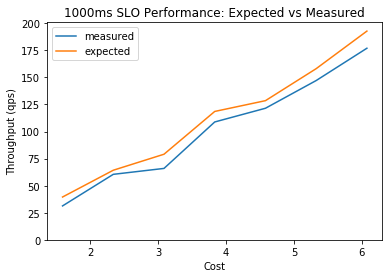

In [31]:
diffs = np.array(e2e_one_second_thrus) - np.array(one_second_thrus)
print("Percentage differences (relative to expectation): {}".format(diffs / one_second_thrus))

plt.plot(e2e_one_second_costs, e2e_one_second_thrus, label="measured")
plt.plot(one_second_costs, one_second_thrus, label="expected")
plt.legend()
plt.ylim(bottom=0)
plt.xlabel("Cost")
plt.ylabel("Throughput (qps)")
plt.title("1000ms SLO Performance: Expected vs Measured")

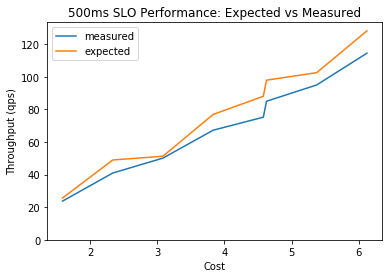

In [32]:
#diffs = np.array(e2e_half_second_thrus) - np.array(half_second_thrus)
#print("Percentage differences (relative to expectation): {}".format(diffs / half_second_thrus))

plt.plot(e2e_half_second_costs, e2e_half_second_thrus, label="measured")
plt.plot(half_second_costs, half_second_thrus, label="expected")
plt.legend()
plt.ylim(bottom=0)
plt.xlabel("Cost")
plt.ylabel("Throughput (qps)")
plt.title("500ms SLO Performance: Expected vs Measured")

## Plot Latencies

In [33]:
def get_latency_stats(df):
    all_lats = []
    means = []
    stds = []
    p99s = []
    costs = []
    for idx, row in df.sort_values("cost").iterrows():
        lats = row["latency"]
        lats = lats.flatten()
        all_lats.append(lats)
        mean = np.mean(lats)
        means.append(mean)
        std = np.std(lats)
        stds.append(std)
        p99 = np.percentile(lats, 99)
        p99s.append(p99)
        cost = row["cost"]
        costs.append(cost)
        
    return costs, all_lats, means, stds, p99s

In [34]:
e2e_min_lat_costs, e2e_min_lat_lats, e2e_min_lat_means, e2e_min_lat_stds, e2e_min_lat_p99s = get_latency_stats(e2e_min_lat_df)
e2e_max_thru_costs, e2e_max_thru_lats, e2e_max_thru_means, e2e_max_thru_stds, e2e_max_thru_p99s = get_latency_stats(e2e_max_thru_df)
e2e_half_second_costs, e2e_half_second_lats, e2e_half_second_means, e2e_half_second_stds, e2e_half_second_p99s = get_latency_stats(e2e_half_second_df)
e2e_one_second_costs, e2e_one_second_lats, e2e_one_second_means, e2e_one_second_stds, e2e_one_second_p99s = get_latency_stats(e2e_one_second_df)

### Min Latency

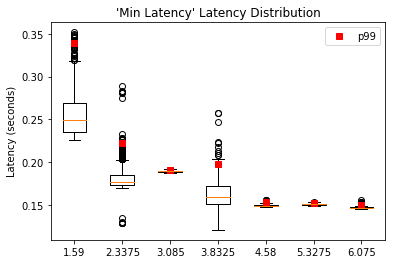

In [35]:
plt.ylabel("Latency (seconds)")
plt.title("'Min Latency' Latency Distribution")
plt.boxplot(e2e_min_lat_lats)
plt.plot(range(1, len(e2e_min_lat_costs) + 1), e2e_min_lat_p99s, "rs", label="p99")
plt.xticks(range(1, len(e2e_min_lat_costs) + 1), e2e_min_lat_costs)
plt.legend()

### Max Throughput

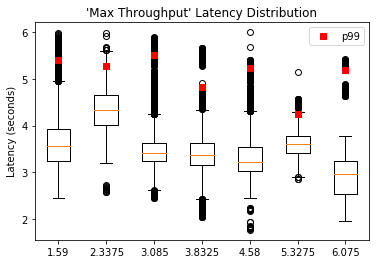

In [36]:
plt.ylabel("Latency (seconds)")
plt.title("'Max Throughput' Latency Distribution")
plt.boxplot(e2e_max_thru_lats)
plt.plot(range(1, len(e2e_max_thru_costs) + 1), e2e_max_thru_p99s, "rs", label="p99")
plt.xticks(range(1, len(e2e_max_thru_costs) + 1), e2e_max_thru_costs)
plt.legend()

### 1000ms

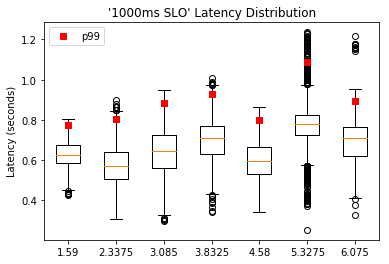

In [37]:
plt.ylabel("Latency (seconds)")
plt.title("'1000ms SLO' Latency Distribution")
plt.boxplot(e2e_one_second_lats)
plt.plot(range(1, len(e2e_one_second_costs) + 1), e2e_one_second_p99s, "rs", label="p99")
plt.xticks(range(1, len(e2e_one_second_costs) + 1), e2e_one_second_costs)
plt.legend()

### 500ms

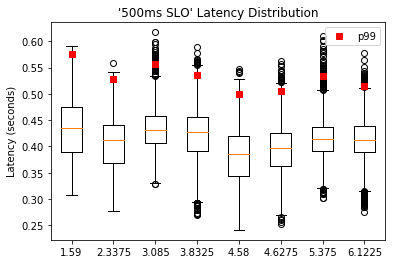

In [38]:
plt.ylabel("Latency (seconds)")
plt.title("'500ms SLO' Latency Distribution")
plt.boxplot(e2e_half_second_lats)
plt.plot(range(1, len(e2e_half_second_costs) + 1), e2e_half_second_p99s, "rs", label="p99")
plt.xticks(range(1, len(e2e_half_second_costs) + 1), e2e_half_second_costs)
plt.legend()

In [39]:
half_second_reps

[({'tf-inception': 1, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 1},
  25.644877367459266),
 ({'tf-inception': 1, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 2},
  48.984991231030754),
 ({'tf-inception': 2, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 2},
  51.289754734918532),
 ({'tf-inception': 2, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 3},
  76.934632102377805),
 ({'tf-inception': 2, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 4},
  88.086103833285023),
 ({'tf-inception': 2, 'tf-ksvm': 2, 'tf-log-reg': 1, 'tf-resnet': 4},
  97.969982462061509),
 ({'tf-inception': 3, 'tf-ksvm': 2, 'tf-log-reg': 1, 'tf-resnet': 4},
  102.57950946983706),
 ({'tf-inception': 3, 'tf-ksvm': 2, 'tf-log-reg': 1, 'tf-resnet': 5},
  128.22438683729632)]

In [40]:
print(min_lat_reps)

[({'tf-log-reg': 1, 'tf-resnet': 1, 'tf-inception': 1, 'tf-ksvm': 1}, 9.2525724150821524), ({'tf-log-reg': 1, 'tf-resnet': 2, 'tf-inception': 1, 'tf-ksvm': 1}, 18.505144830164305), ({'tf-log-reg': 1, 'tf-resnet': 3, 'tf-inception': 1, 'tf-ksvm': 1}, 21.398339349394767), ({'tf-log-reg': 1, 'tf-resnet': 3, 'tf-inception': 2, 'tf-ksvm': 1}, 27.757717245246457), ({'tf-log-reg': 1, 'tf-resnet': 4, 'tf-inception': 2, 'tf-ksvm': 1}, 37.01028966032861), ({'tf-log-reg': 1, 'tf-resnet': 5, 'tf-inception': 2, 'tf-ksvm': 1}, 42.796678698789535), ({'tf-log-reg': 1, 'tf-resnet': 5, 'tf-inception': 3, 'tf-ksvm': 1}, 46.262862075410766)]


In [41]:
half_second_configs

{'tf-inception': (3.8618048618048619, 48.984991231030754, 0.24156295),
 'tf-ksvm': (1.0, 88.086103833285023, 0.020966939999999996),
 'tf-log-reg': (1.0033579795470664, 771.84295351497792, 0.0057492999999999997),
 'tf-resnet': (3.9192071086807929, 25.644877367459266, 0.47764485000000001)}

In [42]:
max_thru_reps

[({'tf-inception': 1, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 1},
  51.435861782134317),
 ({'tf-inception': 1, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 2},
  73.198750383857913),
 ({'tf-inception': 2, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 2},
  102.87172356426863),
 ({'tf-inception': 2, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 3},
  146.39750076771583),
 ({'tf-inception': 3, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 3},
  154.30758534640296),
 ({'tf-inception': 3, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 4},
  205.74344712853727),
 ({'tf-inception': 3, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 5},
  219.59625115157374)]

In [43]:
e2e_half_second_costs

[1.5899999999999999,
 2.3375,
 3.085,
 3.8324999999999996,
 4.58,
 4.6274999999999995,
 5.375,
 6.1225]

In [44]:
half_second_reps

[({'tf-inception': 1, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 1},
  25.644877367459266),
 ({'tf-inception': 1, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 2},
  48.984991231030754),
 ({'tf-inception': 2, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 2},
  51.289754734918532),
 ({'tf-inception': 2, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 3},
  76.934632102377805),
 ({'tf-inception': 2, 'tf-ksvm': 1, 'tf-log-reg': 1, 'tf-resnet': 4},
  88.086103833285023),
 ({'tf-inception': 2, 'tf-ksvm': 2, 'tf-log-reg': 1, 'tf-resnet': 4},
  97.969982462061509),
 ({'tf-inception': 3, 'tf-ksvm': 2, 'tf-log-reg': 1, 'tf-resnet': 4},
  102.57950946983706),
 ({'tf-inception': 3, 'tf-ksvm': 2, 'tf-log-reg': 1, 'tf-resnet': 5},
  128.22438683729632)]

In [45]:
e2e_half_second_thrus

[23.75285141954404,
 40.975051840085662,
 50.135452272577474,
 67.256788094016031,
 75.242545041832201,
 85.037513847267832,
 95.037086330464518,
 114.51945662038459]